## Imports


In [ ]:
import copy
import logging
import os
from pathlib import Path
from typing import Any, Dict, List, Optional

import open_clip
import wandb

import hydra
import omegaconf
import pytorch_lightning as pl
import torch
from hydra import compose, initialize
from hydra.utils import instantiate
from lightning.pytorch import Callback
from omegaconf import DictConfig, ListConfig, OmegaConf
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from nn_core.callbacks import NNTemplateCore
from nn_core.common import PROJECT_ROOT
from nn_core.common.utils import enforce_tags, seed_index_everything
from nn_core.model_logging import NNLogger
from nn_core.serialization import NNCheckpointIO

# Force the execution of __init__.py if this file is executed directly.
import mass  # noqa
from mass.data.datasets.registry import get_dataset
from mass.modules.encoder import ClassificationHead, ImageEncoder
from mass.modules.projection_router import ProjectionRouter
from mass.modules.nn_router import NNRouter
from mass.modules.heads import get_classification_head
from mass.modules.router import AbstractRouter
from mass.utils.io_utils import load_model_from_disk
from mass.utils.plots import plot_interactive_radar_chart
from mass.utils.utils import (
    compute_task_dict, 
    apply_dict_to_model,
    build_callbacks,
    get_finetuning_accuracies,
    add_normalized_accuracy,
    compute_avg_accuracy,
    print_memory,
    get_routing_weights,
    svd_key_from_layer
)
from mass.task_vectors.task_singular_vectors import *
import json
import logging 
import os

pylogger = logging.getLogger(__name__)

torch.set_float32_matmul_precision("high")

/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-05 22:35:06 INFO     PyTorch version 2.0.1 available.                                           ]8;id=801506;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/datasets/config.py\datasets]8;;\:]8;id=261688;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/datasets/config.py#54\54]8;;\

In [3]:
logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)
logging.getLogger("torch").setLevel(logging.WARNING)

In [4]:
%load_ext autoreload
%autoreload 2

In [ ]:
def boilerplate(cfg):
    cfg.core.tags = enforce_tags(cfg.core.get("tags", None))

    num_tasks = len(cfg.eval_datasets)
    cfg.core.tags.append(f"n{num_tasks}")
    cfg.core.tags.append(f'{cfg.nn.module.encoder.model_name}')
    cfg.core.tags.append(f'cifars_notebook')

    template_core = NNTemplateCore(
        restore_cfg=cfg.train.get("restore", None),
    )
    logger: NNLogger = NNLogger(
        logging_cfg=cfg.train.logging, cfg=cfg, resume_id=template_core.resume_id
    )

    logger.upload_source()

    return logger, template_core


def get_merged_base(
    cfg,
    merging_method,
    zeroshot_encoder: ImageEncoder,
    svd_dicts: Dict[str, Any],
):

    coefficient = 1

    if merging_method == "isotropic":

        multi_task_vector = isotropic_sum(
            ref_state_dict=copy.deepcopy(zeroshot_encoder.state_dict()),
            svd_dict=svd_dicts,
        )

        model_name = cfg.nn.module.encoder.model_name

        if (
            model_name in cfg.optimal_alphas
            and len(cfg.eval_datasets) in cfg.optimal_alphas[model_name]
        ):
            coefficient = cfg.optimal_alphas[model_name][len(cfg.eval_datasets)]

    elif merging_method == "tsvm":

        multi_task_vector = sum_svd(
            ref_state_dict=copy.deepcopy(zeroshot_encoder.state_dict()),
            svd_dicts=svd_dicts,
        )
    elif merging_method == "zeroshot":
        return zeroshot_encoder
    else:
        raise NotImplementedError

    merged_encoder: ImageEncoder = copy.deepcopy(zeroshot_encoder)

    merged_encoder = apply_dict_to_model(
        multi_task_vector,
        merged_encoder,
        coefficient=coefficient,
    )

    return merged_encoder


def get_classification_heads(cfg: DictConfig):
    classification_heads = {}

    for dataset_name in cfg.eval_datasets:

        classification_head = get_classification_head(
            cfg.nn.module.encoder.model_name,
            dataset_name,
            cfg.nn.data.data_path,
            cfg.misc.ckpt_path,
            cache_dir=cfg.misc.cache_dir,
            openclip_cachedir=cfg.misc.openclip_cachedir,
        )

        classification_heads[dataset_name] = classification_head

    return classification_heads



In [6]:
import hydra
from hydra import initialize, compose
from typing import Dict, List

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path=str("../conf"), job_name="debug_cifars")
cfg = compose(config_name="task_vectors", overrides=["nn/benchmark=cifars"])

/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py:129: UserWarning: 
'hydra/launcher/submitit_slurm' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
  coro.send(None)


In [7]:

seed_index_everything(cfg)

logger, template_core = boilerplate(cfg)

Global seed set to 1608637542


                    INFO     Setting seed 1608637542 from seeds[0]                         ]8;id=506654;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/common/utils.py\nn_core.common.utils]8;;\:]8;id=125355;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/common/utils.py#107\107]8;;\

                    INFO     Tags: ['similarity_tuning']                                    ]8;id=507214;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/common/utils.py\nn_core.common.utils]8;;\:]8;id=552910;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/common/utils.py#96\96]8;;\

                    INFO     Restoring with mode: <None>                                         ]8;id=346224;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/resume.py\nn_core.resume]8;;\:]8;id=130475;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/resume.py#122\122]8;;\

                    INFO     Instantiating <WandbLogger>                                   ]8;id=170108;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/model_logging.py\nn_core.model_logging]8;;\:]8;id=507338;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/model_logging.py#41\41]8;;\

                    ERROR    Failed to detect the name of this notebook, you can set it manually  ]8;id=25814;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/wandb/jupyter.py\wandb.jupyter]8;;\:]8;id=720665;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/wandb/jupyter.py#224\224]8;;\
                             with the WANDB_NOTEBOOK_NAME environment variable to enable code                      
                             saving.                                                                               

wandb: Currently logged in as: crisostomi (gladia). Use `wandb login --relogin` to force relogin


2025-03-05 22:35:08 INFO     Uploading source code to W&B                                  ]8;id=591644;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/model_logging.py\nn_core.model_logging]8;;\:]8;id=663784;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/nn_core/model_logging.py#63\63]8;;\

In [8]:
# upperbound accuracies, used for logging the normalized accuracy
finetuned_accuracies = get_finetuning_accuracies(cfg.misc.finetuned_accuracy_path)

In [9]:
# only has vision encoder, no text transformer
zeroshot_encoder_statedict = load_model_from_disk(cfg.misc.pretrained_checkpoint)

zeroshot_encoder: ImageEncoder = instantiate(
    cfg.nn.module.encoder
)  # the second pass backbone

zeroshot_encoder.load_state_dict(zeroshot_encoder_statedict, strict=False)

2025-03-05 22:35:16 INFO     Loading ViT-B-32 pre-trained weights.                           ]8;id=560796;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py\tvp.modules.encoder]8;;\:]8;id=355368;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py#17\17]8;;\

                    INFO     Loading pretrained ViT-B-32 from OpenAI.                                       ]8;id=234146;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/open_clip/factory.py\root]8;;\:]8;id=188054;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/open_clip/factory.py#82\82]8;;\

2025-03-05 22:35:18 INFO     Removing text transformer from the model.                       ]8;id=303714;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py\tvp.modules.encoder]8;;\:]8;id=944046;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py#31\31]8;;\

<All keys matched successfully>

In [10]:
finetuned_name = (
    lambda name: Path(cfg.misc.ckpt_path) / f"{name}Val" / "nonlinear_finetuned.pt"
)
finetuned_models = {
    dataset: load_model_from_disk(finetuned_name(dataset))
    for dataset in cfg.task_vectors.to_apply
}

num_tasks = len(cfg.eval_datasets)

pylogger.info(f"Number of tasks: {len(cfg.eval_datasets)}")
pylogger.info(f"Finetuned models: {list(finetuned_models.keys())}")

2025-03-05 22:35:19 INFO     Number of tasks: 3                                                         ]8;id=614797;file:///tmp/ipykernel_90221/188215843.py\__main__]8;;\:]8;id=511817;file:///tmp/ipykernel_90221/188215843.py#11\11]8;;\

                    INFO     Finetuned models: ['CIFAR10', 'CIFAR100', 'STL10']                         ]8;id=8941;file:///tmp/ipykernel_90221/188215843.py\__main__]8;;\:]8;id=219438;file:///tmp/ipykernel_90221/188215843.py#12\12]8;;\

### Visualize some images from CIFAR10, STL10 and CIFAR100

In [11]:
cifar10 = get_dataset(
    'CIFAR10',
    preprocess_fn=zeroshot_encoder.val_preprocess,
    location=cfg.nn.data.data_path,
    batch_size=cfg.nn.data.batch_size.train,
)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
cifar100 = get_dataset(
    'CIFAR100',
    preprocess_fn=zeroshot_encoder.val_preprocess,
    location=cfg.nn.data.data_path,
    batch_size=cfg.nn.data.batch_size.train,
)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
stl10 = get_dataset(
    'STL10',
    preprocess_fn=zeroshot_encoder.val_preprocess,
    location=cfg.nn.data.data_path,
    batch_size=cfg.nn.data.batch_size.train,
)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
## compute statistics

cifar10_val = cifar10.test_loader.dataset
cifar100_val = cifar100.test_loader.dataset
stl10_val = stl10.test_loader.dataset

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def compute_dataset_statistics(dataset, batch_size=256):
    """
    Computes the per-channel mean and standard deviation for a given dataset.
    Note:
      - If the dataset is already normalized/augmented by transforms,
        the computed stats will reflect the *transformed* version.
      - This function assumes images have shape [C, H, W].
    """
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    n_samples = 0
    total_mean = 0.0
    total_std = 0.0
    
    for images, _ in loader:
        # Flatten spatial dimensions: (B, C, H, W) -> (B, C*H*W)
        # so that mean(1) is per-sample, then we average across batch
        # If you want per-channel stats, you can adjust accordingly.
        images = images.view(images.size(0), -1)
        batch_mean = images.mean(dim=1)  # shape [B]
        batch_std = images.std(dim=1)    # shape [B]
        
        total_mean += batch_mean.sum().item()
        total_std += batch_std.sum().item()
        n_samples += images.size(0)

    dataset_mean = total_mean / n_samples
    dataset_std = total_std / n_samples
    return dataset_mean, dataset_std


# cifar10_mean, cifar10_std = compute_dataset_statistics(cifar10_val)
# cifar100_mean, cifar100_std = compute_dataset_statistics(cifar100_val)
# stl10_mean, stl10_std = compute_dataset_statistics(stl10_val)

# print(f"CIFAR10: mean={cifar10_mean:.4f}, std={cifar10_std:.4f}")
# print(f"CIFAR100: mean={cifar100_mean:.4f}, std={cifar100_std:.4f}")
# print(f"STL10: mean={stl10_mean:.4f}, std={stl10_std:.4f}")


Visualizing random CIFAR10 validation samples:


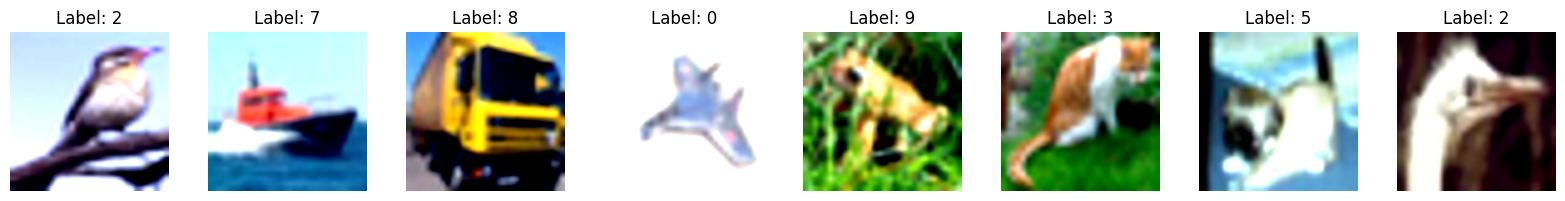

Visualizing random CIFAR100 validation samples:


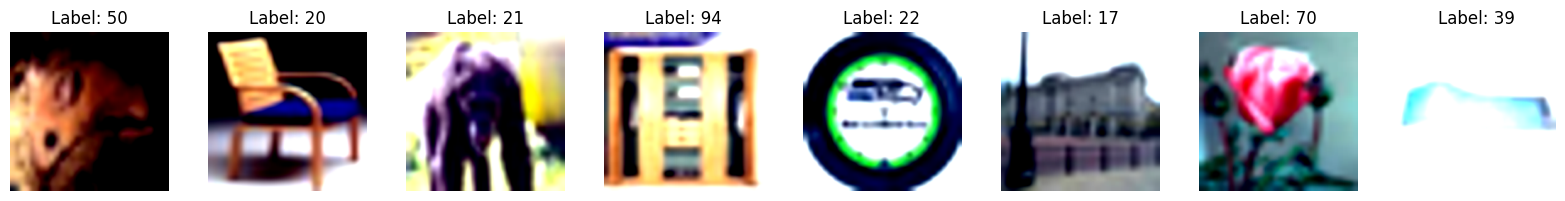

Visualizing random STL10 validation samples:


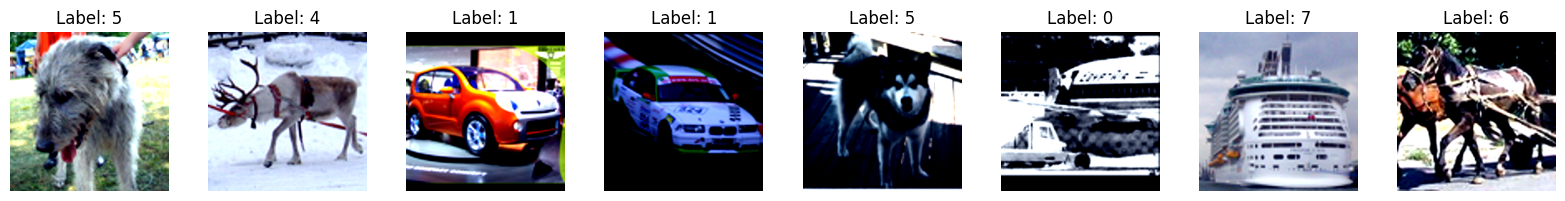

In [16]:

def visualize_random_samples(dataset, n_samples=8):
    """
    Shows a grid of n_samples random images (and their labels) from a dataset.
    Assumes each dataset item is (image, label).
    """
    indices = np.random.choice(len(dataset), size=n_samples, replace=False)
    
    fig, axes = plt.subplots(1, n_samples, figsize=(2 * n_samples, 2))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]  # image shape [C, H, W]


        # Convert tensor -> NumPy and move channels last: [C, H, W] -> [H, W, C]
        image_np = image.permute(1, 2, 0).cpu().numpy()

        image_np = (image_np + 1) / 2.0  # Now in [0, 1]
        image_np = np.clip(image_np, 0, 1)  # Ensure it's strictly within [0, 1]
        
        axes[i].imshow(image_np, cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


print("\nVisualizing random CIFAR10 validation samples:")
visualize_random_samples(cifar10_val, n_samples=8)

print("Visualizing random CIFAR100 validation samples:")
visualize_random_samples(cifar100_val, n_samples=8)

print("Visualizing random STL10 validation samples:")
visualize_random_samples(stl10_val, n_samples=8)

### Test model finetuned on {CIFAR10,CIFAR100, STL10} on {CIFAR10, CIFAR100, STL10} dataset

In [17]:
def evaluate(model, dataset_name, preprocess_fn):

    dataset = get_dataset(
        dataset_name,
        preprocess_fn=preprocess_fn,
        location=cfg.nn.data.data_path,
        batch_size=cfg.nn.data.batch_size.train,
    )

    trainer = pl.Trainer(
        **cfg.train.trainer,
    )

    pylogger.error("For now evaluation supported only on val-set")

    pylogger.info(f"Evaluating on the {dataset_name} test set!")
    test_results = trainer.test(model=model, dataloaders=dataset.test_loader)

    return test_results[0]["acc/test"]


In [18]:
dataset_names = ["CIFAR10", "CIFAR100", "STL10"]

In [19]:
import pandas as pd

from mass.pl_module.image_classifier import ImageClassifier


def try_combinations():
    results = []

    for eval_dataset in dataset_names:
        for ft_dataset, model_dict in finetuned_models.items():

            encoder = instantiate(cfg.nn.module.encoder)
            encoder.load_state_dict(model_dict, strict=False)

            model = ImageClassifier(
                encoder=encoder,
                x_key='x',
                y_key='y',
                classifier=get_classification_head(
                    cfg.nn.module.encoder.model_name,
                    eval_dataset,
                    cfg.nn.data.data_path,
                    cfg.misc.ckpt_path,
                    cache_dir=cfg.misc.cache_dir,
                    openclip_cachedir=cfg.misc.openclip_cachedir,
                ),
            )

            # Evaluate on 'eval_dataset'
            res = evaluate(model, eval_dataset, zeroshot_encoder.val_preprocess)

            # Store the results in a list of dicts
            results.append({
                "eval_dataset": eval_dataset,
                "finetuned_on": ft_dataset,
                "accuracy": res
            })

# results = try_combinations()
results = None 

/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/data/datamodule.py:193: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=str(PROJECT_ROOT / "conf"), config_name="default")


In [20]:

if results:
    df = pd.DataFrame(results)

    df_pivot = df.pivot(index="finetuned_on", columns="eval_dataset", values="accuracy")
    print("\nPivoted view:\n", df_pivot)

### Check CIFAR100 tested over CIFAR10 with the right head

In [21]:

encoder = instantiate(cfg.nn.module.encoder)
encoder.load_state_dict(finetuned_models['CIFAR100'], strict=False)

model = ImageClassifier(
    encoder=encoder,
    x_key='x',
    y_key='y',
    classifier=get_classification_head(
        cfg.nn.module.encoder.model_name,
        'CIFAR10',
        cfg.nn.data.data_path,
        cfg.misc.ckpt_path,
        cache_dir=cfg.misc.cache_dir,
        openclip_cachedir=cfg.misc.openclip_cachedir,
    ),
)

# Evaluate on 'eval_dataset'
res = evaluate(model, 'CIFAR10', zeroshot_encoder.val_preprocess)


2025-03-05 22:36:03 INFO     Loading ViT-B-32 pre-trained weights.                           ]8;id=833390;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py\tvp.modules.encoder]8;;\:]8;id=889220;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py#17\17]8;;\

                    INFO     Loading pretrained ViT-B-32 from OpenAI.                                       ]8;id=782401;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/open_clip/factory.py\root]8;;\:]8;id=829130;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/open_clip/factory.py#82\82]8;;\

2025-03-05 22:36:04 INFO     Removing text transformer from the model.                       ]8;id=172798;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py\tvp.modules.encoder]8;;\:]8;id=315957;file:///media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/src/tvp/modules/encoder.py#31\31]8;;\

Loading classification head from /media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/checkpoints//ViT-B-32/head_CIFAR10.pt


/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified


/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


2025-03-05 22:36:05 ERROR    For now evaluation supported only on val-set                               ]8;id=182222;file:///tmp/ipykernel_90221/2117731721.py\__main__]8;;\:]8;id=25827;file:///tmp/ipykernel_90221/2117731721.py#14\14]8;;\

                    INFO     Evaluating on the CIFAR10 test set!                                        ]8;id=749465;file:///tmp/ipykernel_90221/2117731721.py\__main__]8;;\:]8;id=112816;file:///tmp/ipykernel_90221/2117731721.py#16\16]8;;\

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 313/313 [00:08<00:00, 35.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.8805000185966492     │
│         loss/test         │    0.39370986819267273    │
└───────────────────────────┴───────────────────────────┘

### Merging

In [22]:
task_dicts = {}
for dataset in cfg.task_vectors.to_apply:
    task_dicts[dataset] = compute_task_dict(
        zeroshot_encoder_statedict, finetuned_models[dataset]
    )

In [23]:
from mass.task_vectors.aggregator import WeightedAggregator


aggregator = WeightedAggregator(
    zeroshot_model=zeroshot_encoder.cuda(), 
)

### Best scaling coefficient for CIFARS

In [24]:
import pandas as pd

from mass.pl_module.image_classifier import ImageClassifier


def scaling_coeff_exp():

    results = []

    for scaling_coeff in np.linspace(0, 1, 11):

        merged = aggregator.aggregate(list(task_dicts.values()), scaling_coeff=scaling_coeff)
        for eval_dataset in dataset_names:
            
            model = ImageClassifier(
                encoder=merged,
                x_key='x',
                y_key='y',
                classifier=get_classification_head(
                    cfg.nn.module.encoder.model_name,
                    eval_dataset,
                    cfg.nn.data.data_path,
                    cfg.misc.ckpt_path,
                    cache_dir=cfg.misc.cache_dir,
                    openclip_cachedir=cfg.misc.openclip_cachedir,
                ),
            )

            # Evaluate on 'eval_dataset'
            res = evaluate(model, eval_dataset, zeroshot_encoder.val_preprocess)

            # Store the results in a list of dicts
            results.append({
                "scaling_coeff": scaling_coeff,
                "eval_dataset": eval_dataset,
                "accuracy": res
                })
            
    return results

# results = scaling_coeff_exp()
results = None 

In [25]:
if results:
    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Group by scaling_coeff and compute mean accuracy across all eval datasets
    df_mean = df.groupby("scaling_coeff", as_index=False)["accuracy"].mean()

    # Plot: scaling_coeff (x-axis) vs. average accuracy (y-axis)
    plt.figure()
    plt.plot(df_mean["scaling_coeff"], df_mean["accuracy"], marker="o")  # marker optional
    plt.xlabel("Scaling Coefficient")
    plt.ylabel("Average Accuracy")
    plt.title("Average Accuracy vs. Scaling Coefficient")
    plt.show()

### Test CIFARS with all three heads at the same time

In [26]:
classification_heads = get_classification_heads(cfg)

Loading classification head from /media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/checkpoints//ViT-B-32/head_CIFAR10.pt
Loading classification head from /media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/checkpoints//ViT-B-32/head_CIFAR100.pt
Loading classification head from /media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/checkpoints//ViT-B-32/head_STL10.pt


In [27]:
classification_heads = {dataset: head.cuda() for dataset, head in classification_heads.items()}

In [29]:
import torch.nn.functional as F

merged = aggregator.aggregate(list(task_dicts.values()), scaling_coeff=0.35).cuda()


# We'll define a helper dict to figure out where each dataset's classes lie in the combined logits
# We said the combined logits order is [CIFAR100(0..99), CIFAR10(100..109), STL10(110..119)].
combined_index_offset = {
    "CIFAR100": 0,    # indexes are 0..99
    "CIFAR10":  100,  # indexes are 100..110
    "STL10":   100,   # indexes are 100..100 (same as CIFAR10)
}

with torch.no_grad():

    for dataset_name in dataset_names:

        dataset = get_dataset(
            dataset_name,
            preprocess_fn=zeroshot_encoder.val_preprocess,
            location=cfg.nn.data.data_path,
            batch_size=128,
            num_workers=0,
        )

        total_samples = 0
        correct_single_head = 0
        correct_combined = 0

        for batch in dataset.test_loader:
            images, labels = batch
            images, labels = images.cuda(), labels.cuda()
            
            embeddings = merged(images)

            # 2) Per-head logits
            logits_cifar10   = classification_heads["CIFAR10"](embeddings)    # [B, 10]
            logits_cifar100  = classification_heads["CIFAR100"](embeddings)   # [B, 100]

            # CIFAR10 and STL10 have the same classes except for 7 

            # 3) Combine the logits
            all_logits = torch.cat([logits_cifar100, logits_cifar10], dim=-1)  # [B, 110]

            preds_combined = all_logits.argmax(dim=-1)

            preds = classification_heads[dataset_name](embeddings).argmax(dim=-1)

            # figure out the "correct" index offset
            offset = combined_index_offset[dataset_name]

            correct_index = labels + offset
            correct_combined += (preds_combined == correct_index).sum().item()

            correct_single_head += (preds == labels).sum().item()
            total_samples += images.size(0)

        single_acc = correct_single_head / total_samples
        combined_acc = correct_combined / total_samples

        print(f"[{dataset_name}] Single-head Acc = {single_acc:.4f} | Combined-head Acc = {combined_acc:.4f}")


Files already downloaded and verified
Files already downloaded and verified
[CIFAR10] Single-head Acc = 0.9654 | Combined-head Acc = 0.9242
Files already downloaded and verified
Files already downloaded and verified
[CIFAR100] Single-head Acc = 0.8121 | Combined-head Acc = 0.7876
Files already downloaded and verified
Files already downloaded and verified
[STL10] Single-head Acc = 0.9688 | Combined-head Acc = 0.8930
